In [3]:
import requests
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import pandas as pd

In [1]:
from api_info import *
from credentials import *
from api_functions import *

In [4]:
gameIDs = []
month = '02'
days = range(10,22)
for day in tqdm(days):
    if len(str(day))==1:
        day = "0"+str(day)
    day_url = f"https://api-web.nhle.com/v1/score/2025-{month}-{day}"
    r=requests.get(day_url)
    try:
        gameIDs+=[game["id"] for game in r.json()['games']]
    except:
        print(month,day)
        pass

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


In [5]:
d = retrieve_espn_data(swid,espn_s2,league_id)
data = clean_data(d)

Player has irregular eligible slots: Elias N. Pettersson has slots [10, 4, 6, 7, 8]


In [6]:
def convert_to_default(name):
    parts = name.split()
    return f"{parts[0][0]}. {' '.join(parts[1:])}"


In [24]:
players = data[~data['LeagueTeamID'].isna()]
players['DefaultName'] = players['Name'].apply(convert_to_default)
players.index=players['DefaultName']

C:\Users\georg\AppData\Local\Temp\ipykernel_26980\705551024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['DefaultName'] = players['Name'].apply(convert_to_default)


In [25]:
players_ids = players['LeagueTeamID'].to_dict()

In [26]:
score_cats = ['starter','saves','shotsAgainst','goals','assists','toi','players','sog','hits','blockedShots','pim','plusMinus','faceoffWinningPctg','faceoffplayers','wins','powerPlayGoals','powerPlayAssists']

In [27]:
score_dict = {
    cat:0 for cat in score_cats
}

In [28]:
scores = {
    k:score_dict.copy() for k in range(1,9)
}

In [29]:
all_cats = []
all_tois = {}
for game in tqdm(gameIDs):
    game_url = f"https://api-web.nhle.com/v1/gamecenter/{game}/boxscore"
    try:
        all_player_stats=requests.get(game_url).json()['playerByGameStats']
        for team_type in ['awayTeam','homeTeam']:
            for position in ['forwards','defense','goalies']:
                for player in all_player_stats[team_type][position]:
                    if player['name']['default'] in list(players_ids.keys()):
                        team_id = int(players_ids[player['name']['default']])
                        for cat in player:
                            if cat not in all_cats:
                                all_cats.append(cat)
                            if cat in score_cats and cat!='toi':
                                scores[team_id][cat]+=player[cat]
                            elif cat=='toi':
                                temp_name = player['name']['default']
                                player_time = 60*int(player[cat][0:2])+int(player[cat][3:])
                                scores[team_id][cat]+=player_time
                                if temp_name in all_tois:
                                    all_tois[temp_name].append(player_time)
                                    
                                else:
                                    all_tois[temp_name] = [player_time]
                            if cat=='faceoffWinningPctg' and player[cat]>0:
                                scores[team_id]['faceoffplayers']+=1
                            if cat=='decision':
                                if player[cat]=='W':
                                    scores[team_id]['wins']+=1
                        scores[team_id]['players']+=1
                    else:
                        print('PLAYER NOT IN A TEAM:', player['name']['default'])      
    except KeyError:
        print('No game', game)

 14%|█▍        | 1/7 [00:00<00:02,  2.79it/s]

PLAYER NOT IN A TEAM: A. Hill
PLAYER NOT IN A TEAM: G. Nyquist
PLAYER NOT IN A TEAM: V. Arvidsson
PLAYER NOT IN A TEAM: J. Brodin


 29%|██▊       | 2/7 [00:00<00:01,  2.63it/s]

PLAYER NOT IN A TEAM: N. Hanifin
PLAYER NOT IN A TEAM: J. Slavin
PLAYER NOT IN A TEAM: A. Lundell
PLAYER NOT IN A TEAM: E. Luostarinen
PLAYER NOT IN A TEAM: J. Armia
PLAYER NOT IN A TEAM: E. Haula
PLAYER NOT IN A TEAM: T. Teravainen
PLAYER NOT IN A TEAM: O. Maatta
PLAYER NOT IN A TEAM: H. Jokiharju
PLAYER NOT IN A TEAM: U. Vaakanainen
PLAYER NOT IN A TEAM: E. Lindell
PLAYER NOT IN A TEAM: N. Matinpalo
PLAYER NOT IN A TEAM: N. Mikkola


 43%|████▎     | 3/7 [00:01<00:01,  2.52it/s]

PLAYER NOT IN A TEAM: A. Lundell
PLAYER NOT IN A TEAM: E. Luostarinen
PLAYER NOT IN A TEAM: E. Haula
PLAYER NOT IN A TEAM: T. Teravainen
PLAYER NOT IN A TEAM: O. Maatta
PLAYER NOT IN A TEAM: H. Jokiharju
PLAYER NOT IN A TEAM: U. Vaakanainen
PLAYER NOT IN A TEAM: E. Lindell
PLAYER NOT IN A TEAM: N. Matinpalo
PLAYER NOT IN A TEAM: N. Mikkola
PLAYER NOT IN A TEAM: G. Nyquist
PLAYER NOT IN A TEAM: V. Arvidsson
PLAYER NOT IN A TEAM: J. Brodin


 57%|█████▋    | 4/7 [00:01<00:01,  2.66it/s]

PLAYER NOT IN A TEAM: N. Hanifin
PLAYER NOT IN A TEAM: J. Slavin
PLAYER NOT IN A TEAM: A. Hill


 71%|███████▏  | 5/7 [00:01<00:00,  2.73it/s]

PLAYER NOT IN A TEAM: A. Hill
PLAYER NOT IN A TEAM: A. Lundell
PLAYER NOT IN A TEAM: E. Luostarinen
PLAYER NOT IN A TEAM: J. Armia
PLAYER NOT IN A TEAM: E. Haula
PLAYER NOT IN A TEAM: O. Maatta
PLAYER NOT IN A TEAM: H. Jokiharju
PLAYER NOT IN A TEAM: U. Vaakanainen
PLAYER NOT IN A TEAM: E. Lindell
PLAYER NOT IN A TEAM: N. Matinpalo
PLAYER NOT IN A TEAM: N. Mikkola


 86%|████████▌ | 6/7 [00:02<00:00,  2.91it/s]

PLAYER NOT IN A TEAM: G. Nyquist
PLAYER NOT IN A TEAM: V. Arvidsson
PLAYER NOT IN A TEAM: L. Carlsson
PLAYER NOT IN A TEAM: J. Brodin
PLAYER NOT IN A TEAM: S. Ersson
PLAYER NOT IN A TEAM: N. Hanifin
PLAYER NOT IN A TEAM: J. Slavin


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

PLAYER NOT IN A TEAM: A. Hill
PLAYER NOT IN A TEAM: N. Hanifin
PLAYER NOT IN A TEAM: J. Slavin


In [30]:
all_tois_average = {}
for player in all_tois:
    all_tois_average[player]=np.mean(all_tois[player])

In [31]:
all_tois_average_list = list(all_tois_average.items())
all_tois_average_list.sort(key=lambda x:x[1])

In [32]:
all_tois_average_list.reverse()

In [33]:
all_tois_average_list

[('J. Binnington', 3790.75),
 ('C. Hellebuyck', 3766.0),
 ('J. Saros', 1820.0),
 ('K. Lankinen', 1737.3333333333333),
 ('F. Gustavsson', 1717.3333333333333),
 ('C. Makar', 1606.6666666666667),
 ('V. Hedman', 1518.6666666666667),
 ('D. Toews', 1445.75),
 ('B. Faber', 1400.25),
 ('G. Forsling', 1332.0),
 ('A. Barkov', 1305.0),
 ('J. Morrissey', 1292.3333333333333),
 ('J. Guentzel', 1275.75),
 ('C. McDavid', 1256.0),
 ('L. Ullmark', 1249.0),
 ('J. Eichel', 1247.0),
 ('Z. Werenski', 1241.75),
 ('M. Rantanen', 1235.3333333333333),
 ('M. Zibanejad', 1230.5),
 ('A. Matthews', 1226.0),
 ('W. Nylander', 1211.6666666666667),
 ('T. Harley', 1206.5),
 ('D. Doughty', 1197.25),
 ('J. Eriksson Ek', 1183.6666666666667),
 ('C. McAvoy', 1176.0),
 ('C. Parayko', 1151.5),
 ('S. Aho', 1119.6666666666667),
 ('N. MacKinnon', 1116.0),
 ('J. Sanderson', 1106.0),
 ('L. Raymond', 1099.6666666666667),
 ('E. Karlsson', 1088.6666666666667),
 ('A. Kempe', 1082.0),
 ('J. Hughes', 1074.75),
 ('M. Marner', 1070.25),
 (

In [34]:
for team_id in range(1,9):
    scores[team_id]['atoi']=scores[team_id]['toi']/scores[team_id]['players']/60
    if scores[team_id]['shotsAgainst']==0:
        scores[team_id]['savePctg']=0
    else:
        scores[team_id]['savePctg']=scores[team_id]['saves']/scores[team_id]['shotsAgainst']
    scores[team_id]['powerPlayPoints']=scores[team_id]['powerPlayGoals']+scores[team_id]['powerPlayAssists']

In [35]:
final_score_cats = ['powerPlayPoints','starter','savePctg','goals','assists','atoi','sog','hits','blockedShots','pim','plusMinus','faceoffWinningPctg','wins']

In [36]:

for cat in scores[1]:
    highest = 0
    highest_team = []
    for i in range(1,9):
        if scores[i][cat]/scores[i]['players']>highest:
            highest = scores[i][cat]/scores[i]['players']
            highest_team=[i]
        elif scores[i][cat]/scores[i]['players']==highest:
            highest_team.append(i)

    print(cat,highest_team,highest)

starter [2, 8] 0.14285714285714285
saves [8] 3.4642857142857144
shotsAgainst [8] 3.8214285714285716
goals [3] 0.38235294117647056
assists [8] 0.5
toi [8] 1497.7857142857142
players [1, 2, 3, 4, 5, 6, 7, 8] 1.0
sog [6, 8] 2.0
hits [3] 1.7941176470588236
blockedShots [3] 1.0294117647058822
pim [5] 0.5185185185185185
plusMinus [8] 0.2857142857142857
faceoffWinningPctg [3] 0.33352767647058823
faceoffplayers [3] 0.5
wins [8] 0.10714285714285714
powerPlayGoals [5] 0.07407407407407407
powerPlayAssists [1, 2, 3, 4, 5, 6, 7, 8] 0
atoi [2] 1.1418367346938776
savePctg [2] 0.0444015444015444
powerPlayPoints [5] 0.07407407407407407


In [38]:

for cat in scores[1]:
    highest = 0
    highest_team = []
    for i in range(1,9):
        if scores[i][cat]>highest:
            highest = scores[i][cat]
            highest_team=[i]
        elif scores[i][cat]==highest:
            highest_team.append(i)

    print(cat,highest_team,highest)

powerPlayPoints [3, 5] 2
starter [8] 4
savePctg [2] 0.9324324324324325
goals [3] 13
assists [8] 14
atoi [8] 24.96309523809524
sog [3] 65
hits [3] 61
blockedShots [1] 41
pim [1] 16
plusMinus [8] 8
faceoffWinningPctg [3] 11.339941
wins [8] 3


In [ ]:
for team_id in range(1,9):
    scores[team_id] = {k:scores[team_id][k] for k in final_score_cats}

KeyError: 'players'

In [39]:
team_week_scores = {}
team_matrix = np.zeros((8,8))
min_weeks = 0
weeks = 18

for team_id in scores:
    wins = 0
    draws = 0
    losses = 0
    total_cat_wins = 0
    total_cat_losses = 0
    total_cat_draws = 0
    for second_team_id in scores:
        if team_id==second_team_id:
            continue
        cats_won = 0
        cats_lost = 0
        team = scores[team_id]
        second_team = scores[second_team_id]
        for score_cat in team:
            if team[score_cat]>second_team[score_cat]:
                cats_won+=1
            elif team[score_cat]<second_team[score_cat]:
                cats_lost+=1
        total_cat_wins+=cats_won
        total_cat_losses+=cats_lost
        total_cat_draws+=13-cats_won-cats_lost
        if cats_won>cats_lost:
            wins+=1
            team_matrix[team_id-1,second_team_id-1]+=1
            team_matrix[second_team_id-1,team_id-1]-=1
        elif cats_won<cats_lost:
            losses+=1
            team_matrix[team_id-1,second_team_id-1]-=1
            team_matrix[second_team_id-1,team_id-1]+=1
        else:
            draws+=1
        # if week == 15 and team_id==8:
            # print('ID', second_team_id,'Winning',cats_won,'Losing',cats_lost)
    if team_id in team_week_scores:
        team_week_scores[team_id]+=np.array([wins,losses,draws,total_cat_wins,total_cat_losses,total_cat_draws])
    else:
        team_week_scores[team_id]=np.array([wins,losses,draws,total_cat_wins,total_cat_losses,total_cat_draws])
    

In [40]:
sorted(team_week_scores.items(),key=lambda x:x[1][0],reverse=True)

[(8, array([ 6,  0,  1, 60, 26,  5])),
 (3, array([ 5,  1,  1, 56, 27,  8])),
 (1, array([ 4,  0,  3, 53, 29,  9])),
 (2, array([ 3,  2,  2, 45, 36, 10])),
 (5, array([ 3,  3,  1, 53, 32,  6])),
 (7, array([ 2,  5,  0, 38, 42, 11])),
 (6, array([ 1,  6,  0, 16, 61, 14])),
 (4, array([ 0,  7,  0,  5, 73, 13]))]

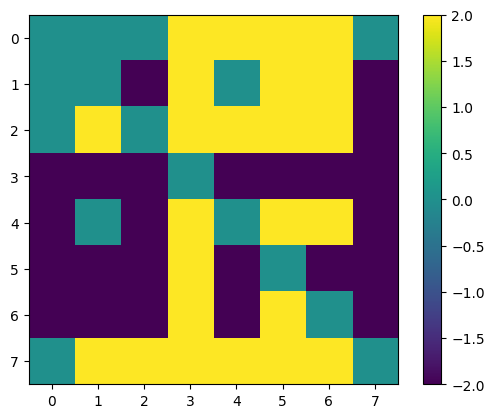

In [41]:
plt.imshow(team_matrix)
plt.colorbar()